In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

Downloading the dataset with flowers (divided in folders):

In [5]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
save_dir = '/datasets/'
os.makedirs(save_dir, exist_ok=True)
dataset_dir = os.path.join(save_dir, 'flower_photos')

if not os.path.exists(dataset_dir):
    # If it doesn't exist, download and extract the dataset
    dataset_tar = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
    dataset_dir = pathlib.Path(dataset_tar).with_suffix('').resolve()
    
    # Move the extracted dataset to the desired save directory
    os.rename(dataset_dir, os.path.join(save_dir, 'flower_photos'))
    dataset_dir = os.path.join(save_dir, 'flower_photos')

# dataset_dir = pathlib.Path('flower_photos/')

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

print(f"Number of images:", len(list(dataset_dir.glob("*/*.jpg"))))

228813984/228813984 [==============================] - 2s 0us/step
Number of images: 3670


Splitting the dataset in training and validation subsets:

In [6]:
batch_size = 32 # This is the Number of images processed at once. More pictures = more perfomance needed + faster training + lower model precision
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=1337,
	image_size=(img_height, img_width),
	batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=1337,
	image_size=(img_height, img_width),
	batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Tensorflow recommend to cache the dataset elements:

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model creation.
We will use simple sequential NN model. Since the dataset is pretty small, we use augmentation to extend it.

In [8]:
num_classes = len(class_names)
model = Sequential([
  # Preprocessing layer (rescale values to be between 0 and 1):
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# Augmentation:
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

  # Main layers
	layers.Conv2D(16, 3, padding='same', activation='relu'), # layer that contains filters
	layers.MaxPooling2D(), # downsampling layer that reduces the dimensionality of each feature map while retaining the most important information

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# Regularization:
  layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

Model compilation:

In [9]:
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      4

Training the model and saving the results:

In [11]:
epochs = 10
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# We can manually save the model weights:
model.save_weights('tf_flowers_classification')
print('Model is saved.')

Epoch 1/10
92/92 [==============================] - 129s 1s/step - loss: 1.0208 - accuracy: 0.5971 - val_loss: 1.0579 - val_accuracy: 0.5926
Epoch 2/10
92/92 [==============================] - 150s 2s/step - loss: 0.9564 - accuracy: 0.6298 - val_loss: 1.0357 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 131s 1s/step - loss: 0.9015 - accuracy: 0.6492 - val_loss: 0.8763 - val_accuracy: 0.6335
Epoch 4/10
92/92 [==============================] - 133s 1s/step - loss: 0.8325 - accuracy: 0.6802 - val_loss: 0.9233 - val_accuracy: 0.6594
Epoch 5/10
92/92 [==============================] - 123s 1s/step - loss: 0.7907 - accuracy: 0.7006 - val_loss: 1.1369 - val_accuracy: 0.5804
Epoch 6/10
92/92 [==============================] - 124s 1s/step - loss: 0.7584 - accuracy: 0.7074 - val_loss: 0.8338 - val_accuracy: 0.6826
Epoch 7/10
92/92 [==============================] - 122s 1s/step - loss: 0.7027 - accuracy: 0.7245 - val_loss: 0.8467 - val_accuracy: 0.6553
Epoch 8/10
92

Last step is to create graphs using 'history' variable containing the accuracy and loss function of model for each epoch:

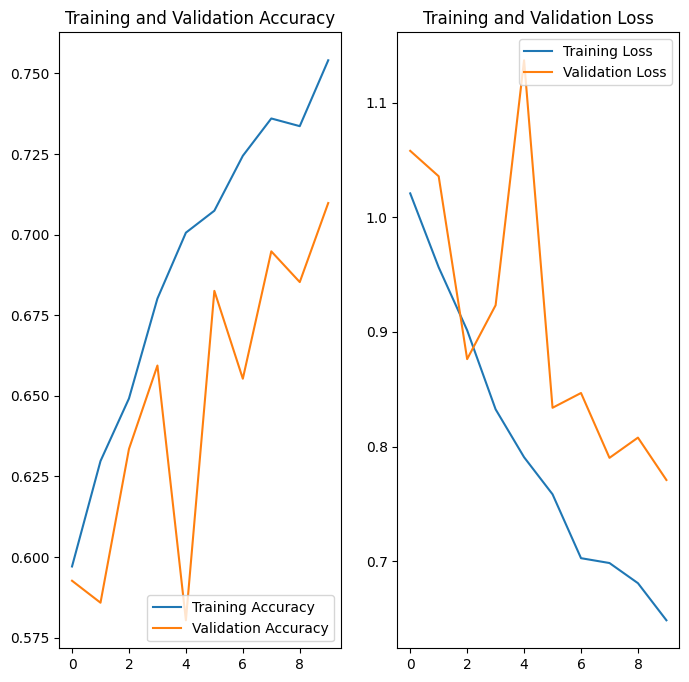

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Using the saved model for prediction.
We can use the trained model for prediction, but we can also load the saved weights in another model instance, let's do it:

In [14]:
# Creating the same model and loading the saved weights
model_loaded = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
  layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

model_loaded.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

model_loaded.load_weights('tf_flowers_classification') # use the name of the saved model

Evaluating the model:

In [16]:
loss, acc = model_loaded.evaluate(train_ds, verbose=2)
print('Loaded model, accuracy: {:5.2f}%'.format(100*acc))

92/92 - 28s - loss: 0.5306 - accuracy: 0.7943 - 28s/epoch - 301ms/step
Loaded model, accuracy: 79.43%


In [17]:
loss, acc = model.evaluate(train_ds, verbose=2)
print('Loaded model, accuracy: {:5.2f}%'.format(100*acc))
# the results are the same

92/92 - 29s - loss: 0.5306 - accuracy: 0.7943 - 29s/epoch - 314ms/step
Loaded model, accuracy: 79.43%


For the last step we need to load an image to our directory:

In [18]:
# loading the image (choose a flower image):
img = tf.keras.utils.load_img("test-image.jpg", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

And finally classification step:

In [20]:
predictions = model.predict(img_array)
score =tf.nn.softmax(predictions[0])

print("Picture contain {} ({:.2f}% probability)".format(
    class_names[np.argmax(score)],
    100*np.max(score)
))

1/1 [==============================] - 0s 32ms/step
Picture contain roses (77.26% probability)


### Summary:
The model achieved an accuracy of around 80% within just 10 epochs, which is pretty good for a model with a straightforward architecture.